In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa

from official.nlp import optimization  # to create AdamW optimizer
from transformers import create_optimizer

tf.get_logger().setLevel('ERROR')

In [3]:
num_epochs = 12
batch_size = 32
max_seq_length = 256

In [4]:
%config Completer.use_jedi = False
%matplotlib inline

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
def tokenize(claim, evidence):
    x = tokenizer(claim, evidence, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="tf")
    return x["input_ids"], x["attention_mask"], x["token_type_ids"]

def preprocess_dataset(dataset):
    input_ids = np.zeros((len(dataset), max_seq_length))
    attention_masks = np.zeros((len(dataset), max_seq_length))
    token_type_ids = np.zeros((len(dataset), max_seq_length))
    
    dataset.reset_index(drop=True, inplace=True)
    
    # loop through data and tokenize everything
    for i, row in dataset.iterrows():
        input_ids[i, :], attention_masks[i, :], token_type_ids[i, :] = tokenize(row["Claim"], row["Evidence"])
        
    # Encoding labels
    lb = LabelBinarizer()
    lb.fit([0, 1, 2])
    
    labels = lb.transform(dataset.Label.values)
    
    return input_ids, attention_masks, token_type_ids, labels

def map_func(input_ids, attention_mask, token_type_ids, labels):
    return {'input_ids': input_ids, 'attention_mask': attention_mask, "token_type_ids": token_type_ids}, labels

In [6]:
# open dataset
train_data = pd.read_csv("dataset/train_update.csv")
# Splitting into train and validation sets
train_set, validation_set = train_test_split(train_data, random_state=123, shuffle=True, test_size=0.2)


train_input_ids, train_masks, train_token_type_ids, train_labels = preprocess_dataset(train_set)
val_input_ids, val_masks, val_token_type_ids, val_labels = preprocess_dataset(validation_set)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_input_ids, train_masks, train_token_type_ids, train_labels))
train_ds = train_ds.map(map_func).shuffle(10000).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_input_ids, val_masks, val_token_type_ids, val_labels))
val_ds = val_ds.map(map_func).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
def build_model(trainable_encoder=True, dropout_rate=0.3):
    input_ids = tf.keras.Input(shape=(max_seq_length, ), dtype='int32', name="input_ids")
    attention_mask = tf.keras.Input(shape=(max_seq_length, ), dtype='int32', name="attention_mask")
    token_type_ids = tf.keras.Input(shape=(max_seq_length, ), dtype='int32', name="token_type_ids")

    encoded_ouput = bert_model({"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids})
    x = GlobalMaxPooling1D(name="global_max_pooling1d")(encoded_ouput["last_hidden_state"])
    x = Dropout(dropout_rate, name="dropout")(x)
    output = Dense(3, activation='softmax', name='outputs')(x)

    model = tf.keras.models.Model(inputs={"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}, outputs=output)

    # freeze the encoder network
    model.layers[2].trainable = trainable_encoder
    return model

In [14]:
model = build_model(dropout_rate=0.5)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]            

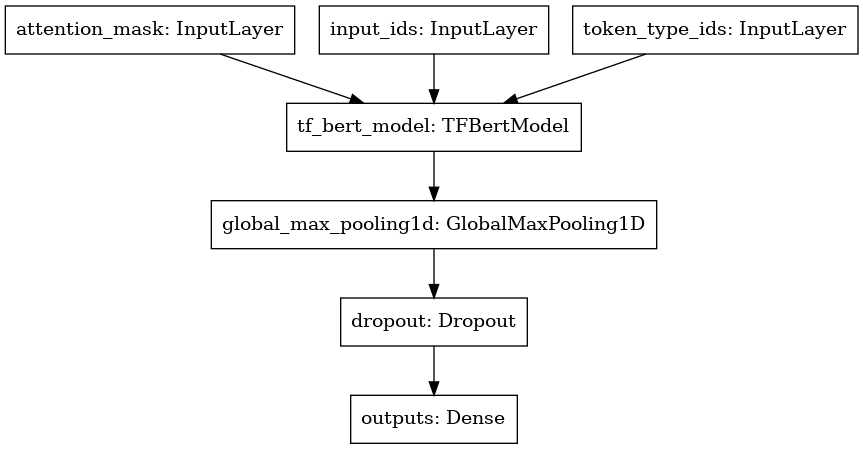

In [15]:
tf.keras.utils.plot_model(model)

In [10]:
batches_per_epoch = len(train_set) // batch_size
num_train_steps = int(batches_per_epoch * num_epochs)
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
    init_lr=5e-5, num_warmup_steps=num_warmup_steps, num_train_steps=num_train_steps
)

# optimizer = tfa.optimizers.AdamW(0.005, learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')]
)

In [11]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/12
30/30 [==============================] - 39s 712ms/step - loss: 1.6388 - accuracy: 0.4146 - val_loss: 0.9315 - val_accuracy: 0.5254
Epoch 2/12
30/30 [==============================] - 18s 593ms/step - loss: 1.0681 - accuracy: 0.5005 - val_loss: 0.7292 - val_accuracy: 0.7119
Epoch 3/12
30/30 [==============================] - 18s 595ms/step - loss: 0.7417 - accuracy: 0.6522 - val_loss: 0.5927 - val_accuracy: 0.7161
Epoch 4/12
30/30 [==============================] - 18s 597ms/step - loss: 0.6045 - accuracy: 0.7116 - val_loss: 0.5975 - val_accuracy: 0.7076
Epoch 5/12
30/30 [==============================] - 18s 597ms/step - loss: 0.5038 - accuracy: 0.7656 - val_loss: 0.5747 - val_accuracy: 0.7161
Epoch 6/12
30/30 [==============================] - 18s 598ms/step - loss: 0.3764 - accuracy: 0.8176 - val_loss: 0.5833 - val_accuracy: 0.7119
Epoch 7/12
30/30 [==============================] - 18s 599ms/step - loss: 0.3453 - accuracy: 0.8431 - val_loss: 0.5159 - val_accuracy: 0.7797

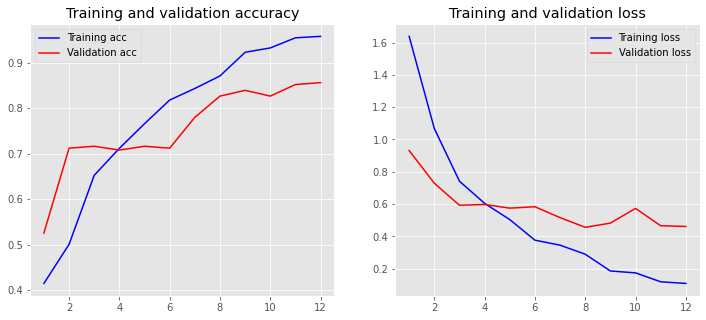

In [15]:
plot_history(history)

In [16]:
predicted = model.predict(val_ds)
y_pred = np.argmax(predicted, axis=1)
y_true = np.argmax(val_labels, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        53
           1       0.91      0.83      0.86       127
           2       0.70      0.80      0.75        56

    accuracy                           0.86       236
   macro avg       0.85      0.87      0.86       236
weighted avg       0.86      0.86      0.86       236



In [17]:
model.evaluate(val_ds)

8/8 [==============================] - 1s 178ms/step - loss: 0.4611 - accuracy: 0.8559


[0.46114397048950195, 0.8559321761131287]

In [18]:
# model.save("models/bert-base-uncased_5e-5_b32.h5")

In [29]:
# test_data = pd.read_csv("dataset/test_phase_1_update.csv")

# # loop through data and tokenize everything
# for i, row in test_data.iterrows():
#     input_ids, attention_mask, token_type_ids = tokenize(row["Claim"], row["Evidence"])
#     p = model.predict({"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids})
#     label = np.argmax(p, axis=1)[0]
#     print(label)

0
0
1
1
1
0
0
2
2
1
1
1
1
2
1
1
0
2
0
0
1
1
1
1
2
1
1
1
1
0
1
1
2
2
1
1
1
1
1
0
0
1
0
0
1
1
1
0
0
1
1
1
0
1
1
0
2
2
1
1
0
1
0
2
2
1
1
0
0
1
1
0
0
2
1
1
1
2
0
0
0
0
1
1
1
2
1
1
1
1
2
0
0
2
0
0
2
2
1
1
2
0
1
1
0
0
1
1
1
1
0
1
2
0
2
2
2
2
0
1
2
1
1
1
1
2
1
1
1
0
1
2
1
0
0
2
1
1
0
1
1
0
1
0
1
0
2
0
0
1
